# Introduction

Elections are a fundamental part of modern democracy, involving a complex interplay between individuals, institutions, and information. Understanding how elections unfold — how voters behave, how campaigns influence them, and how outcomes emerge — is a major challenge in computational social science.

Traditionally, researchers have tackled this problem using:
- Agent-based simulations
- Opinion dynamics models like the DeGroot and voter models
- Statistical approaches based on historical data

While these methods have provided valuable insights, they often suffer from:
- High-dimensional parameter spaces
- Limited analytical tractability

In contrast, biological systems — particularly those studied in computational systems biology — offer elegant models for complex, nonlinear interactions among populations.  
Famous examples include:
- The SIR model for disease spread
- The Lotka-Volterra predator-prey equations

![alt text][def]

These biological models capture rich emergent behaviours with simple, low-dimensional dynamics.

In this work, we explore how **biological frameworks** can be applied to **model electoral dynamics**. We draw parallels between the spread of opinions and the transmission of diseases, treating campaigning as a **contagious process**. Similarly, we adapt **predator-prey models** to represent strategic competition between candidates and voter groups.

For example:
- **Undecided voters** are treated as **"susceptible"**
- **Party influence** is treated as **"infection"**
- **Decided voters** are treated as **"recovered"**

We simulate how support spreads and stabilises, and analyse how competition between candidates affects vote shares.

Through simulations and comparisons with traditional political models, we aim to show that **biologically-inspired approaches** offer a powerful, interpretable lens for understanding elections — blending insights from biology, mathematics, and social science.


[def]: ./ppl.jpg

# Agent Based Modelling

Agent-Based Modeling (ABM) to simulate:

- Election dynamics with voter, candidate, and media agents.

- Opinion dynamics using a DeGroot-style averaging process.

The models are built using the Mesa library and NetworkX for network structures.

In [1]:
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

# Voter Agent

Represents individual voters.

## Attributes:
- state: 'A', 'B', or 'S' (undecided).
- resistance: Resistance to changing opinion.
- decay_prob: Chance of reverting to undecided.
- threshold: Fraction of neighbors needed to influence change.
- group: Social group ('Urban', 'Rural', etc.).
- (x, y): Geographical coordinates.

## Behavior:
- Changes state based on neighbors' states and threshold.
- Has a decay mechanism (back to undecided).
- Resistance increases if state changes.

In [ ]:
class VoterAgent(Agent):
    def __init__(self, unique_id, model, initial_state='S', resistance=0.1, decay_prob=0.05, threshold=0.5, group=None, x=0, y=0):
        super().__init__(unique_id, model)
        self.state = initial_state
        self.resistance = resistance
        self.previous_state = initial_state
        self.decay_prob = decay_prob
        self.threshold = threshold
        self.group = group or self.random.choice(['Youth', 'Senior', 'Urban', 'Rural'])
        self.x = x  # Geographic X position
        self.y = y  # Geographic Y position

    def step(self):
        if self.state in ['A', 'B'] and self.random.random() < self.decay_prob:
            self.state = 'S'
            return

        if self.state != 'S':
            return

        neighbors = self.model.grid.get_neighbors(self.pos)
        influence_A = sum(1 for n in neighbors if n.state == 'A')
        influence_B = sum(1 for n in neighbors if n.state == 'B')
        total = len(neighbors)

        if total == 0:
            return

        if influence_A / total >= self.threshold:
            new_state = 'A'
        elif influence_B / total >= self.threshold:
            new_state = 'B'
        else:
            return

        if self.random.random() > self.resistance:
            if self.previous_state != new_state:
                self.resistance = min(1.0, self.resistance + 0.1)
            self.previous_state = self.state
            self.state = new_state

    def get_distance(self, other_agent):
        return ((self.x - other_agent.x)**2 + (self.y - other_agent.y)**2)**0.5


# Media Agent
Represents media events influencing voters.

### Attributes:
- target: Targeted party ('A' or 'B').
- influence_strength: Strength of media influence.
- trigger_step: How often media triggers.

### Behavior:
- Influences undecided voters at specified steps.

In [ ]:
class MediaAgent(Agent):
    def __init__(self, unique_id, model, target='A', influence_strength=0.3, trigger_step=10):
        super().__init__(unique_id, model)
        self.target = target  
        self.influence_strength = influence_strength  
        self.trigger_step = trigger_step 

    def step(self):
        if self.model.schedule.steps % self.trigger_step == 0:
            for a in self.model.schedule.agents:
                if isinstance(a, VoterAgent) and a.state == 'S':  
                    prob = self.influence_strength
                    if self.random.random() < prob:
                        a.state = self.target 

# Candidate Agent
Represents a political candidate.

### Attributes:
- party: 'A' or 'B'.
- reach_prob: Probability of influencing voters.

### Behavior:
- Adjusts strategy if behind in support.
- Influences nearby undecided voters based on distance.

In [ ]:
class CandidateAgent(Agent): 
    def __init__(self, unique_id, model, party, reach_prob=0.1):
        super().__init__(unique_id, model)
        self.party = party
        self.reach_prob = reach_prob
        self.x = self.random.random()
        self.y = self.random.random()

    def get_distance(self, other_agent):
        """
        Calculate the Euclidean distance between this candidate and another agent (voter or media).
        """
        if isinstance(other_agent, VoterAgent) or isinstance(other_agent, MediaAgent):
            # Compute Euclidean distance
            distance = ((self.x - other_agent.x) ** 2 + (self.y - other_agent.y) ** 2) ** 0.5
            return distance
        else:
            return None
        
    def step(self):
        support = {'A': 0, 'B': 0, 'S': 0}
        for a in self.model.schedule.agents:
            if isinstance(a, VoterAgent):
                support[a.state] += 1

        if self.party == 'A' and support['A'] < support['B']:
            self.reach_prob = min(1.0, self.reach_prob + 0.05)
        elif self.party == 'B' and support['B'] < support['A']:
            self.reach_prob = min(1.0, self.reach_prob + 0.05)

        for a in self.model.schedule.agents:
            if isinstance(a, VoterAgent) and a.state == 'S':
                distance = self.get_distance(a)
                influence = self.reach_prob / (1 + distance) 
                if self.random.random() < influence:
                    a.state = self.party



# ElectionModel
Initializes a stochastic block model network.
Places VoterAgents on the network nodes.
Adds CandidateAgents and MediaAgents.
Collects data on the number of voters for each party over time.

### Parameters:
- N: Number of voters.
- decay_prob: Probability of decaying to undecided.
- threshold: Minimum neighbor influence to change opinion.
- media_count: Number of media agents.
- communities: Number of voter communities.

### Methods:
- step(): Advances the model by one step.
- hold_election(): Tallies the votes at the end.

In [ ]:
class ElectionModel(Model):
    def __init__(self, N=100, decay_prob=0.05, threshold=0.5, media_count=2, communities=3):
        # Create a probability matrix for the stochastic block model
        # p[i][j] is the probability of an edge between nodes in community i and community j
        p = [[0.2 if i != j else 0.4 for i in range(communities)] for j in range(communities)]
        
        # Create a stochastic block model graph
        self.G = nx.stochastic_block_model([N//communities]*communities, p)
        
        self.grid = NetworkGrid(self.G)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            model_reporters={
                'A': lambda m: sum(1 for a in m.schedule.agents if isinstance(a, VoterAgent) and a.state == 'A'),
                'B': lambda m: sum(1 for a in m.schedule.agents if isinstance(a, VoterAgent) and a.state == 'B'),
                'S': lambda m: sum(1 for a in m.schedule.agents if isinstance(a, VoterAgent) and a.state == 'S'),
            }
        )

        for node_id in self.G.nodes:
            group = 'Urban' if node_id % 2 == 0 else 'Rural'
            x, y = self.random.random(), self.random.random()
            a = VoterAgent(node_id, self, decay_prob=decay_prob, threshold=threshold, group=group, x=x, y=y)
            self.grid.place_agent(a, node_id)  
            self.schedule.add(a)

        for i in range(media_count):
            target = 'A' if i % 2 == 0 else 'B'
            media_agent = MediaAgent(f'media_{i}', self, target=target, influence_strength=0.3, trigger_step=10)
            self.schedule.add(media_agent)

        self.candA = CandidateAgent('candA', self, party='A')
        self.candB = CandidateAgent('candB', self, party='B')
        self.schedule.add(self.candA)
        self.schedule.add(self.candB)

        self.final_results = None

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

    def hold_election(self):
        vote_counts = {'A': 0, 'B': 0}
        for a in self.schedule.agents:
            if isinstance(a, VoterAgent):
                if a.state in ['A', 'B']:
                    vote_counts[a.state] += 1
        self.final_results = vote_counts
        print("\nElection Results:")
        print(f"Candidate A: {vote_counts['A']} votes")
        print(f"Candidate B: {vote_counts['B']} votes")

In [ ]:
def run_model(N=100, steps=30, decay_prob=0.05, threshold=0.5, media_count=2, communities=3):
    model = ElectionModel(N=N, decay_prob=decay_prob, threshold=threshold, media_count=media_count, communities=communities)
    for _ in range(steps):
        model.step()

    results = model.datacollector.get_model_vars_dataframe()
    results.plot(marker='o', figsize=(10, 6), grid=True, title="Election Dynamics")
    plt.xlabel("Step")
    plt.ylabel("Number of Voters")
    plt.show()

    model.hold_election()

widgets.interact(
    run_model,
    N=widgets.IntSlider(value=100, min=20, max=300, step=10, description='Voters'),
    steps=widgets.IntSlider(value=30, min=10, max=100, step=5, description='Steps'),
    decay_prob=widgets.FloatSlider(value=0.05, min=0.0, max=0.2, step=0.01, description='Decay Prob'),
    threshold=widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.05, description='Threshold'),
    media_count=widgets.IntSlider(value=2, min=1, max=5, step=1, description='Media Agents'),
    communities=widgets.IntSlider(value=3, min=2, max=5, step=1, description='Communities')
)

interactive(children=(IntSlider(value=100, description='Voters', max=300, min=20, step=10), IntSlider(value=30…

<function __main__.run_model(N=100, steps=30, decay_prob=0.05, threshold=0.5, media_count=2, communities=3)>

In [4]:
import random

# OpinionAgent

Represents an individual with an opinion (0 to 1).

### Attributes:
- opinion: Numerical opinion value.
- neighbors: List of connected agents.

### Behavior:
- Updates opinion based on the weighted average of neighbors' opinions.

In [5]:
class OpinionAgent(Agent):
    """ An agent with an opinion, based on DeGroot's model. """
    def __init__(self, unique_id, model, opinion, neighbors):
        super().__init__(unique_id, model)
        self.opinion = opinion  # Opinion of the agent (between 0 and 1, for example)
        self.neighbors = neighbors  # List of neighboring agents

    def step(self):
        # Update the agent's opinion based on the weighted average of neighbors' opinions
        total_opinion = 0
        total_weight = 0
        for neighbor in self.neighbors:
            weight = self.model.get_weight(self, neighbor)
            total_opinion += weight * neighbor.opinion
            total_weight += weight
        # Normalize the opinion to be between 0 and 1 (optional)
        self.opinion = total_opinion / total_weight if total_weight != 0 else self.opinion

class OpinionDynamicsModel(Model):
    """ The model for simulating opinion dynamics using DeGroot's model. """
    def __init__(self, num_agents, width, height):
        self.num_agents = num_agents
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents with random initial opinions between 0 and 1
        for i in range(self.num_agents):
            opinion = random.random()  # Random initial opinion
            # Assuming a random connection for simplicity here
            neighbors = []  # Initially, no neighbors
            a = OpinionAgent(i, self, opinion, neighbors)
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        # Data collection
        self.datacollector = DataCollector(
            agent_reporters={"Opinion": "opinion"}
        )

    def get_weight(self, agent1, agent2):
        # Simple function to define the weight of one agent's influence on another.
        # This could be based on social distance, network connection, etc.
        # For simplicity, here we use a fixed weight
        return 1 / len(agent1.neighbors) if len(agent1.neighbors) > 0 else 1

    def step(self):
        # Collect data for each step
        self.datacollector.collect(self)

        # Update opinions of all agents
        self.schedule.step()

In [6]:
# Run the model
model = OpinionDynamicsModel(100, 10, 10)

for i in range(100):  # Run for 100 steps
    model.step()

# Extract data for analysis
data = model.datacollector.get_agent_vars_dataframe()
print(data.tail())

               Opinion
Step AgentID          
99   80       0.815022
     10       0.130207
     15       0.538147
     14       0.590788
     34       0.687977


C:\Users\alanr\AppData\Local\Temp\ipykernel_6752\3538373494.py:4: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


# ARIMA

In [7]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv("1976-2020-senate.csv")

In [9]:
df
df_mod = df[df['stage'] == 'gen']
df_mod = df_mod[df_mod['party_simplified'].isin(['REPUBLICAN', 'DEMOCRAT'])]
grouped = df_mod.groupby(['year', 'party_simplified'])['candidatevotes'].sum().unstack().fillna(0)
grouped['Total'] = grouped.sum(axis=1)
grouped['DEMOCRAT_pct'] = 100 * grouped['DEMOCRAT'] / grouped['Total']
grouped['REPUBLICAN_pct'] = 100 * grouped['REPUBLICAN'] / grouped['Total']

In [10]:
dem_votes = grouped['DEMOCRAT_pct']

# Fit ARIMA model (p=1, d=1, q=1 as example)
model = ARIMA(dem_votes, order=(1,1,1))
model_fit = model.fit()

forecast = model_fit.predict(start=0, end=len(dem_votes)-1, typ='levels')

C:\Users\alanr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\alanr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\alanr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, 

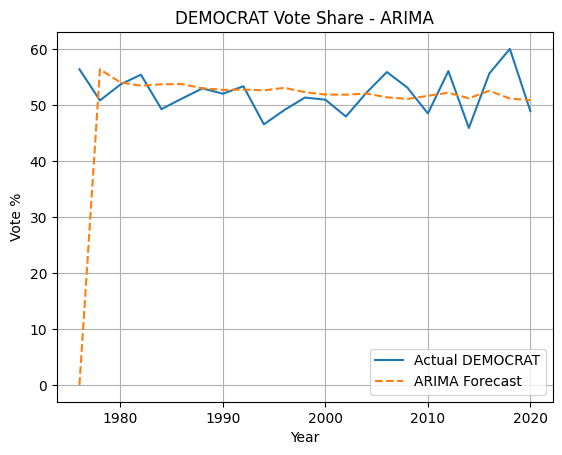

In [11]:
plt.plot(dem_votes.index, dem_votes, label='Actual DEMOCRAT')
plt.plot(dem_votes.index, forecast, label='ARIMA Forecast', linestyle='--')
plt.legend()
plt.title("DEMOCRAT Vote Share - ARIMA")
plt.xlabel("Year")
plt.ylabel("Vote %")
plt.grid(True)
plt.show()

# VAR

In [12]:
from statsmodels.tsa.api import VAR
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv("1976-2020-senate.csv")

In [14]:
df
df_mod = df[df['stage'] == 'gen']
df_mod = df_mod[df_mod['party_simplified'].isin(['REPUBLICAN', 'DEMOCRAT'])]
grouped = df_mod.groupby(['year', 'party_simplified'])['candidatevotes'].sum().unstack().fillna(0)
grouped['Total'] = grouped.sum(axis=1)
grouped['DEMOCRAT_pct'] = 100 * grouped['DEMOCRAT'] / grouped['Total']
grouped['REPUBLICAN_pct'] = 100 * grouped['REPUBLICAN'] / grouped['Total']

In [15]:
vote_df = grouped[['DEMOCRAT_pct', 'REPUBLICAN_pct']]

model = VAR(vote_df)
results = model.fit(maxlags=2)

lag_order = results.k_ar
forecast_input = vote_df.values[-lag_order:]
forecast = results.forecast(y=forecast_input, steps=len(vote_df))

C:\Users\alanr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [16]:
forecast_df = pd.DataFrame(forecast, columns=['DEMOCRAT_forecast', 'REPUBLICAN_forecast'], index=vote_df.index)

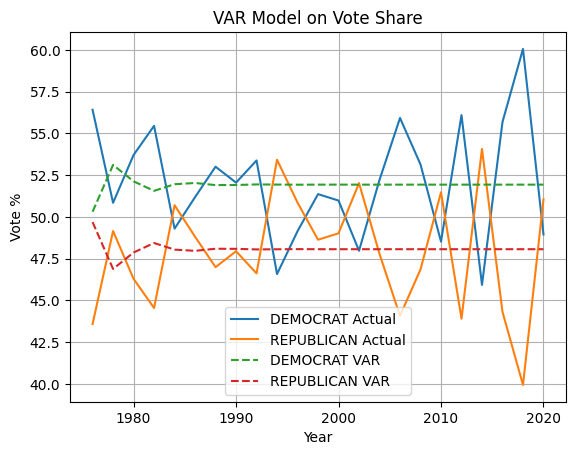

In [17]:
plt.plot(vote_df.index, vote_df['DEMOCRAT_pct'], label='DEMOCRAT Actual')
plt.plot(vote_df.index, vote_df['REPUBLICAN_pct'], label='REPUBLICAN Actual')
plt.plot(vote_df.index, forecast_df['DEMOCRAT_forecast'], '--', label='DEMOCRAT VAR')
plt.plot(vote_df.index, forecast_df['REPUBLICAN_forecast'], '--', label='REPUBLICAN VAR')
plt.title("VAR Model on Vote Share")
plt.xlabel("Year")
plt.ylabel("Vote %")
plt.legend()
plt.grid(True)
plt.show()

# S Curve

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

In [19]:
df
df_mod = df[df['stage'] == 'gen']
df_mod = df_mod[df_mod['party_simplified'].isin(['REPUBLICAN', 'DEMOCRAT'])]
grouped = df_mod.groupby(['year', 'party_simplified'])['candidatevotes'].sum().unstack().fillna(0)
grouped['Total'] = grouped.sum(axis=1)
grouped['DEMOCRAT_pct'] = 100 * grouped['DEMOCRAT'] / grouped['Total']
grouped['REPUBLICAN_pct'] = 100 * grouped['REPUBLICAN'] / grouped['Total']

In [20]:
years = grouped.index.values
t = years - years[0]
vote_A = grouped['DEMOCRAT_pct'].values
vote_B = grouped['REPUBLICAN_pct'].values

In [21]:
def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

In [22]:
x = np.array(t)
y = vote_A

In [23]:
params, _ = curve_fit(logistic, x, y, p0=[60, 0.2, 10])
L, k, x0 = params

In [24]:
y_fit = logistic(x, L, k, x0)

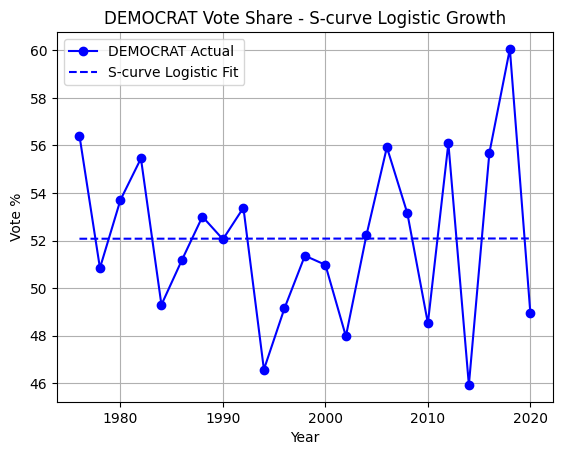

In [25]:
plt.plot(years, y, 'bo-', label="DEMOCRAT Actual")
plt.plot(years, y_fit, 'b--', label="S-curve Logistic Fit")
plt.title("DEMOCRAT Vote Share - S-curve Logistic Growth")
plt.xlabel("Year")
plt.ylabel("Vote %")
plt.grid(True)
plt.legend()
plt.show()

# Neural ODE

In [26]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
class ODEFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 2)
        )
    def forward(self, t, y):
        return self.net(y)


In [28]:
df = pd.read_csv("1976-2020-senate.csv")

In [29]:
df
df_mod = df[df['stage'] == 'gen']
df_mod = df_mod[df_mod['party_simplified'].isin(['REPUBLICAN', 'DEMOCRAT'])]
grouped = df_mod.groupby(['year', 'party_simplified'])['candidatevotes'].sum().unstack().fillna(0)
grouped['Total'] = grouped.sum(axis=1)
grouped['DEMOCRAT_pct'] = 100 * grouped['DEMOCRAT'] / grouped['Total']
grouped['REPUBLICAN_pct'] = 100 * grouped['REPUBLICAN'] / grouped['Total']
vote_df = grouped[['DEMOCRAT_pct', 'REPUBLICAN_pct']]


In [30]:
y0 = torch.tensor([vote_df.iloc[0].values], dtype=torch.float32)
t = torch.linspace(0, len(vote_df)-1, len(vote_df))
y_data = torch.tensor(vote_df.values, dtype=torch.float32)

C:\Users\alanr\AppData\Local\Temp\ipykernel_6752\2638541814.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  y0 = torch.tensor([vote_df.iloc[0].values], dtype=torch.float32)


In [31]:
func = ODEFunc()
optimizer = torch.optim.Adam(func.parameters(), lr=0.01)

In [32]:
for epoch in range(1000):
    pred_y = odeint(func, y0[0], t)
    loss = torch.mean((pred_y - y_data)**2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 34.0296
Epoch 100, Loss: 11.4533
Epoch 200, Loss: 11.3252
Epoch 300, Loss: 11.2512
Epoch 400, Loss: 11.1909
Epoch 500, Loss: 11.1492
Epoch 600, Loss: 11.1203
Epoch 700, Loss: 11.0991
Epoch 800, Loss: 11.0826
Epoch 900, Loss: 11.0691


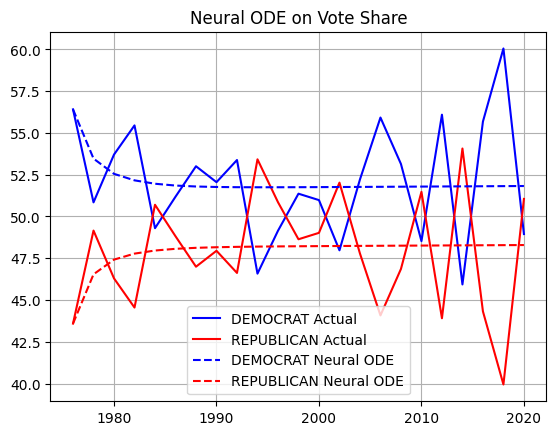

In [33]:
pred = pred_y.detach().numpy()
plt.plot(vote_df.index, vote_df['DEMOCRAT_pct'], 'b', label='DEMOCRAT Actual')
plt.plot(vote_df.index, vote_df['REPUBLICAN_pct'], 'r', label='REPUBLICAN Actual')
plt.plot(vote_df.index, pred[:,0], 'b--', label='DEMOCRAT Neural ODE')
plt.plot(vote_df.index, pred[:,1], 'r--', label='REPUBLICAN Neural ODE')
plt.title("Neural ODE on Vote Share")
plt.legend()
plt.grid(True)
plt.show()

# PINNS

In [34]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
df = pd.read_csv("1976-2020-senate.csv")

In [36]:
df
df_mod = df[df['stage'] == 'gen']
df_mod = df_mod[df_mod['party_simplified'].isin(['REPUBLICAN', 'DEMOCRAT'])]
grouped = df_mod.groupby(['year', 'party_simplified'])['candidatevotes'].sum().unstack().fillna(0)
grouped['Total'] = grouped.sum(axis=1)
grouped['DEMOCRAT_pct'] = 100 * grouped['DEMOCRAT'] / grouped['Total']
grouped['REPUBLICAN_pct'] = 100 * grouped['REPUBLICAN'] / grouped['Total']
vote_df = grouped[['DEMOCRAT_pct', 'REPUBLICAN_pct']]

In [37]:
years = grouped.index.values
t = years - years[0]
vote_A = grouped['DEMOCRAT_pct'].values
vote_B = grouped['REPUBLICAN_pct'].values

In [38]:
D = vote_A # dem
R = vote_B # rep
t = (years - years[0]) / (years[-1] - years[0])

In [39]:
t = torch.tensor(t, dtype=torch.float32).unsqueeze(1).requires_grad_(True)
D = torch.tensor(D / 100.0, dtype=torch.float32).unsqueeze(1)
R = torch.tensor(R / 100.0, dtype=torch.float32).unsqueeze(1)

In [40]:
Y = torch.cat([D, R], dim=1)

In [41]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 2)
        )

    def forward(self, t):
        return self.net(t)

In [42]:
def pinn_loss(model, t, y_obs):
    y_pred = model(t)
    D_pred, R_pred = y_pred[:, 0:1], y_pred[:, 1:2]

    # Compute derivatives w.r.t time
    dydt = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred),
                               retain_graph=True, create_graph=True)[0]
    dDdt = dydt[:, 0:1]
    dRdt = dydt[:, 1:2]

    # Physics-inspired constraints (example: prey-predator like dynamics)
    f1 = dDdt - (D_pred * (1 - D_pred) - D_pred * R_pred)
    f2 = dRdt - (-R_pred + D_pred * R_pred)

    # Loss: data fitting + physics constraint
    data_loss = torch.mean((y_pred - y_obs)**2)
    physics_loss = torch.mean(f1**2) + torch.mean(f2**2)
    return data_loss + physics_loss, data_loss.detach(), physics_loss.detach()


In [43]:
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [44]:
for epoch in range(5000):
    optimizer.zero_grad()
    loss, data_l, phys_l = pinn_loss(model, t, Y)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Total Loss={loss.item():.6f}, Data={data_l:.6f}, Physics={phys_l:.6f}")


Epoch 0: Total Loss=nan, Data=0.045218, Physics=nan
Epoch 500: Total Loss=nan, Data=0.001052, Physics=nan
Epoch 1000: Total Loss=nan, Data=0.001039, Physics=nan
Epoch 1500: Total Loss=nan, Data=0.001045, Physics=nan
Epoch 2000: Total Loss=nan, Data=0.001033, Physics=nan
Epoch 2500: Total Loss=nan, Data=0.001031, Physics=nan
Epoch 3000: Total Loss=nan, Data=0.001029, Physics=nan
Epoch 3500: Total Loss=nan, Data=0.001028, Physics=nan
Epoch 4000: Total Loss=nan, Data=0.001025, Physics=nan
Epoch 4500: Total Loss=nan, Data=0.001023, Physics=nan


In [45]:
with torch.no_grad():
    pred = model(t)
    D_pred = pred[:, 0].numpy() * 100
    R_pred = pred[:, 1].numpy() * 100

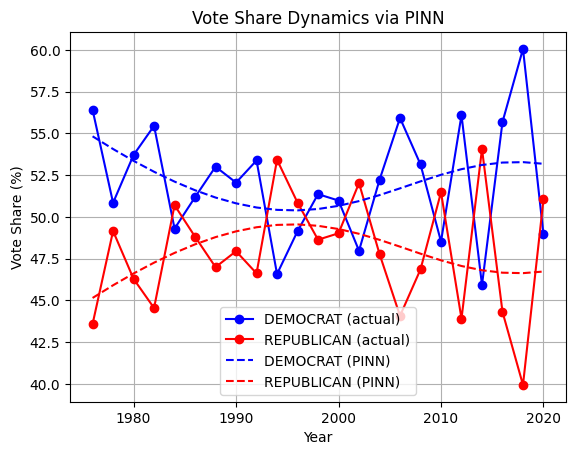

In [46]:
plt.plot(years, D.numpy().squeeze() * 100, 'bo-', label='DEMOCRAT (actual)')
plt.plot(years, R.numpy().squeeze() * 100, 'ro-', label='REPUBLICAN (actual)')
plt.plot(years, D_pred, 'b--', label='DEMOCRAT (PINN)')
plt.plot(years, R_pred, 'r--', label='REPUBLICAN (PINN)')
plt.xlabel("Year")
plt.ylabel("Vote Share (%)")
plt.legend()
plt.title("Vote Share Dynamics via PINN")
plt.grid(True)
plt.show()

# SIR Model

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import math

In [48]:
df = pd.read_csv("1976-2020-senate.csv")

In [49]:
selected_states = ['NEW HAMPSHIRE', 'NORTH CAROLINA', 'OKLAHOMA', 'OREGON', 'SOUTH CAROLINA', 'SOUTH DAKOTA']
filtered_df = df[df['state'].isin(selected_states)]

In [50]:
states = filtered_df['state'].unique()
party_order = ['REPUBLICAN', 'DEMOCRAT']
colors = {'REPUBLICAN': 'red', 'DEMOCRAT': 'blue'} # BONUS 
df_dict = {}

plot_index = 0
for state in states:
    for party in party_order:
        state_party_data = df[(df['state'] == state) & (df['party_simplified'] == party)  & (df['special'] == False)]
        state_party_data = state_party_data[state_party_data['writein'] == False]
        df_dict[(state, party)] = state_party_data

In [51]:
cols = ['year', 'candidatevotes', 'totalvotes']
df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')][cols]

,year,candidatevotes,totalvotes
221,1978,133745,263760
346,1980,195559,375060
607,1984,225828,384369
719,1986,154090,244735
956,1990,189792,291393
1100,1992,249591,518170
1415,1996,242257,491873
1568,1998,213477,314696
1905,2002,227229,447135
2059,2004,434847,657086


In [52]:
def sir_model(t, y, beta, gamma):
    '''' y is tuple with 
    (S, I, R) - > (Voters (infuencible), Opioniated voters (voter percentage for chosen candidate), Recovered (Voters who change sides) 
    
    '''
    S, I, R = y
    dSdt = -beta * S * I # It can go both ways ? 
    dIdt = beta * S * I - gamma * I # what is the mechanism for this. What is gamma a function of ? 
    dRdt = gamma * I # potenitally, beta and gamma are funcitons of time ? 
    return [dSdt, dIdt, dRdt]

In [53]:
def fit_sir_model(t, beta, gamma, S0, I0, R0):
    '''What is the return value?'''
    sol = solve_ivp(sir_model, [t[0], t[-1]], [S0, I0, R0], t_eval=t, args=(beta, gamma))
    return sol.y[1] # returns S, I, R as they change wrt time. y[1] gives I 

In [54]:
year = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['year'].values
votes = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['candidatevotes'].values
total_votes = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['totalvotes'].values
vote_percentage = votes / total_votes
I0 = vote_percentage[0]
S0 = 1 - I0
R0 = 0

# fit the curve provided initial guess. 0.1 each | Gives local optimum
params, covariance = curve_fit(fit_sir_model, year, vote_percentage, p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))
beta, gamma = params[:2]
print(f"Fitted parameters: beta={beta}, gamma={gamma}")

Fitted parameters: beta=0.05437961621978311, gamma=0.03446399192118356


In [55]:
fitted_voter_percentage = fit_sir_model(year, *params)

In [56]:
split_index = int(0.8 * len(year))

X_train, X_test = year[:split_index], year[split_index:]
y_train, y_test = vote_percentage[:split_index], vote_percentage[split_index:]
params, covariance = curve_fit(fit_sir_model, X_train, y_train, p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))
beta, gamma = params[:2]
print(f"Fitted parameters: beta={beta}, gamma={gamma}")
test_fit = (fit_sir_model(year, *params))

Fitted parameters: beta=0.5672019667303213, gamma=0.0036563196181867703


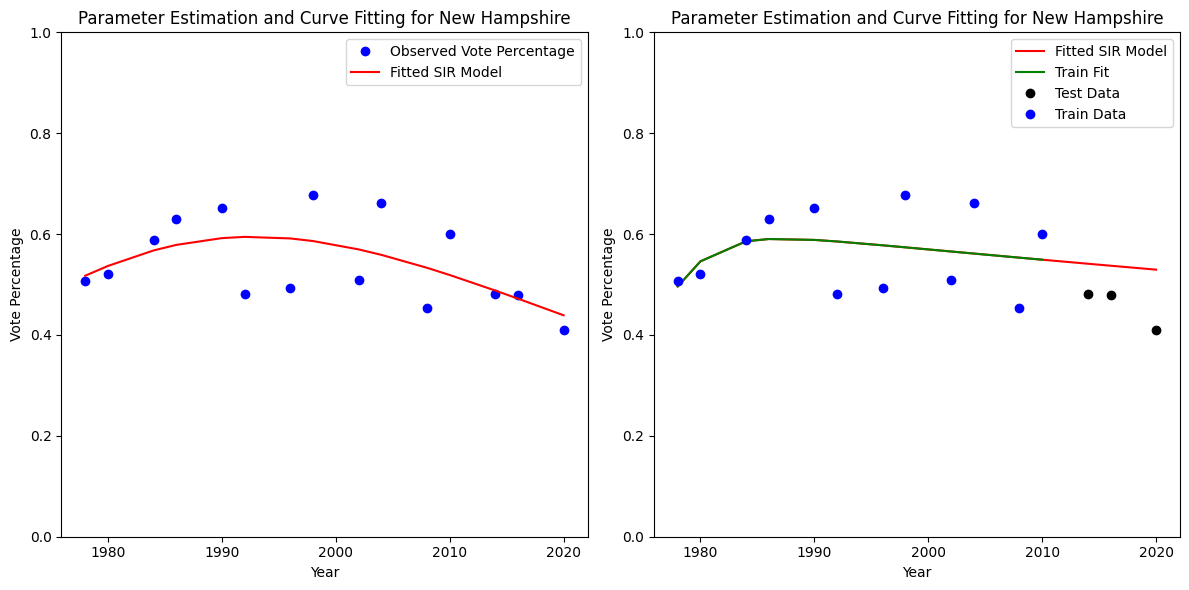

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First plot
axes[0].plot(year, vote_percentage, 'bo', label='Observed Vote Percentage')
axes[0].plot(year, fitted_voter_percentage, 'r-', label='Fitted SIR Model')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Vote Percentage')
axes[0].set_ylim(0, 1)
axes[0].legend()
axes[0].set_title('Parameter Estimation and Curve Fitting for New Hampshire')

# Second plot
axes[1].plot(year, test_fit, 'r-', label='Fitted SIR Model')
axes[1].plot(X_train, fit_sir_model(X_train, *params), 'g-', label='Train Fit')
axes[1].plot(X_test, y_test, 'ko', label='Test Data')
axes[1].plot(X_train, y_train, 'bo', label='Train Data')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Vote Percentage')
axes[1].set_ylim(0, 1)
axes[1].legend()
axes[1].set_title('Parameter Estimation and Curve Fitting for New Hampshire')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

In [58]:
year = df_dict[('OREGON', 'REPUBLICAN')]['year'].values
votes = df_dict[('OREGON', 'REPUBLICAN')]['candidatevotes'].values
total_votes = df_dict[('OREGON', 'REPUBLICAN')]['totalvotes'].values
vote_percentage = votes / total_votes
split_index = int(0.8 * len(year))

X_train, X_test = year[:split_index], year[split_index:]
y_train, y_test = vote_percentage[:split_index], vote_percentage[split_index:]
I0 = vote_percentage[0]
S0 = 1 - I0
R0 = 0

# fit the curve provided initial guess. 0.1 each | Gives local optimum
params, covariance = curve_fit(fit_sir_model, X_train, y_train, p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))
beta, gamma = params[:2]
test_fit = (fit_sir_model(year, *params))
print(f"Fitted parameters: beta={beta}, gamma={gamma}")

Fitted parameters: beta=0.4666418583578674, gamma=0.01909952616941452


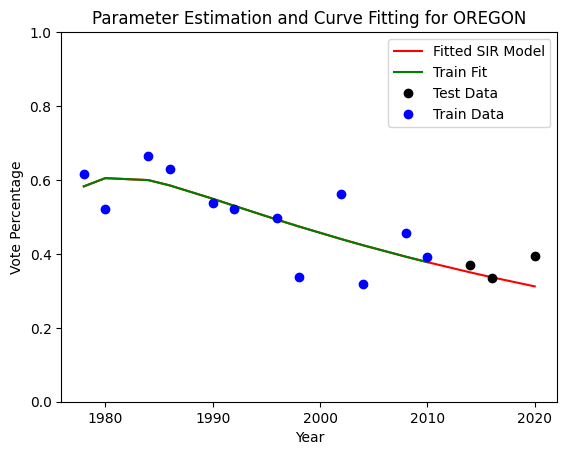

In [59]:
plt.plot(year, test_fit, 'r-', label='Fitted SIR Model')
plt.plot(X_train, fit_sir_model(X_train, *params), 'g-', label='Train Fit')
plt.plot(X_test, y_test, 'ko', label='Test Data')
plt.plot(X_train, y_train, 'bo', label='Train Data')
plt.xlabel('Year')
plt.ylabel('Vote Percentage')
plt.ylim(0, 1)
plt.legend()
plt.title('Parameter Estimation and Curve Fitting for OREGON')
plt.show()

Other states

In [60]:
selected_states = ['NEW HAMPSHIRE', 'NORTH CAROLINA', 'OKLAHOMA', 'OREGON', 'SOUTH CAROLINA', 'SOUTH DAKOTA']
filtered_df = df[df['state'].isin(selected_states)]

Fitted parameters: beta=0.05437961621978311, gamma=0.03446399192118356 for the state NEW HAMPSHIRE and party REPUBLICAN
Fitted parameters: beta=0.005354808264849727, gamma=3.6105930129196283e-10 for the state NEW HAMPSHIRE and party DEMOCRAT
Fitted parameters: beta=5.4468594745835664e-08, gamma=0.001353707023072259 for the state NORTH CAROLINA and party REPUBLICAN
Fitted parameters: beta=0.9999999997747073, gamma=0.0010870326336350742 for the state NORTH CAROLINA and party DEMOCRAT
Fitted parameters: beta=0.03995613292777673, gamma=0.011846148522003433 for the state OKLAHOMA and party REPUBLICAN
Fitted parameters: beta=0.3522694521782574, gamma=0.02737286108756838 for the state OKLAHOMA and party DEMOCRAT
Fitted parameters: beta=0.5511528126244002, gamma=0.016392618712990678 for the state OREGON and party REPUBLICAN
Fitted parameters: beta=0.03470691317176693, gamma=0.014649297120569102 for the state OREGON and party DEMOCRAT
Fitted parameters: beta=0.020089020398668216, gamma=0.011249

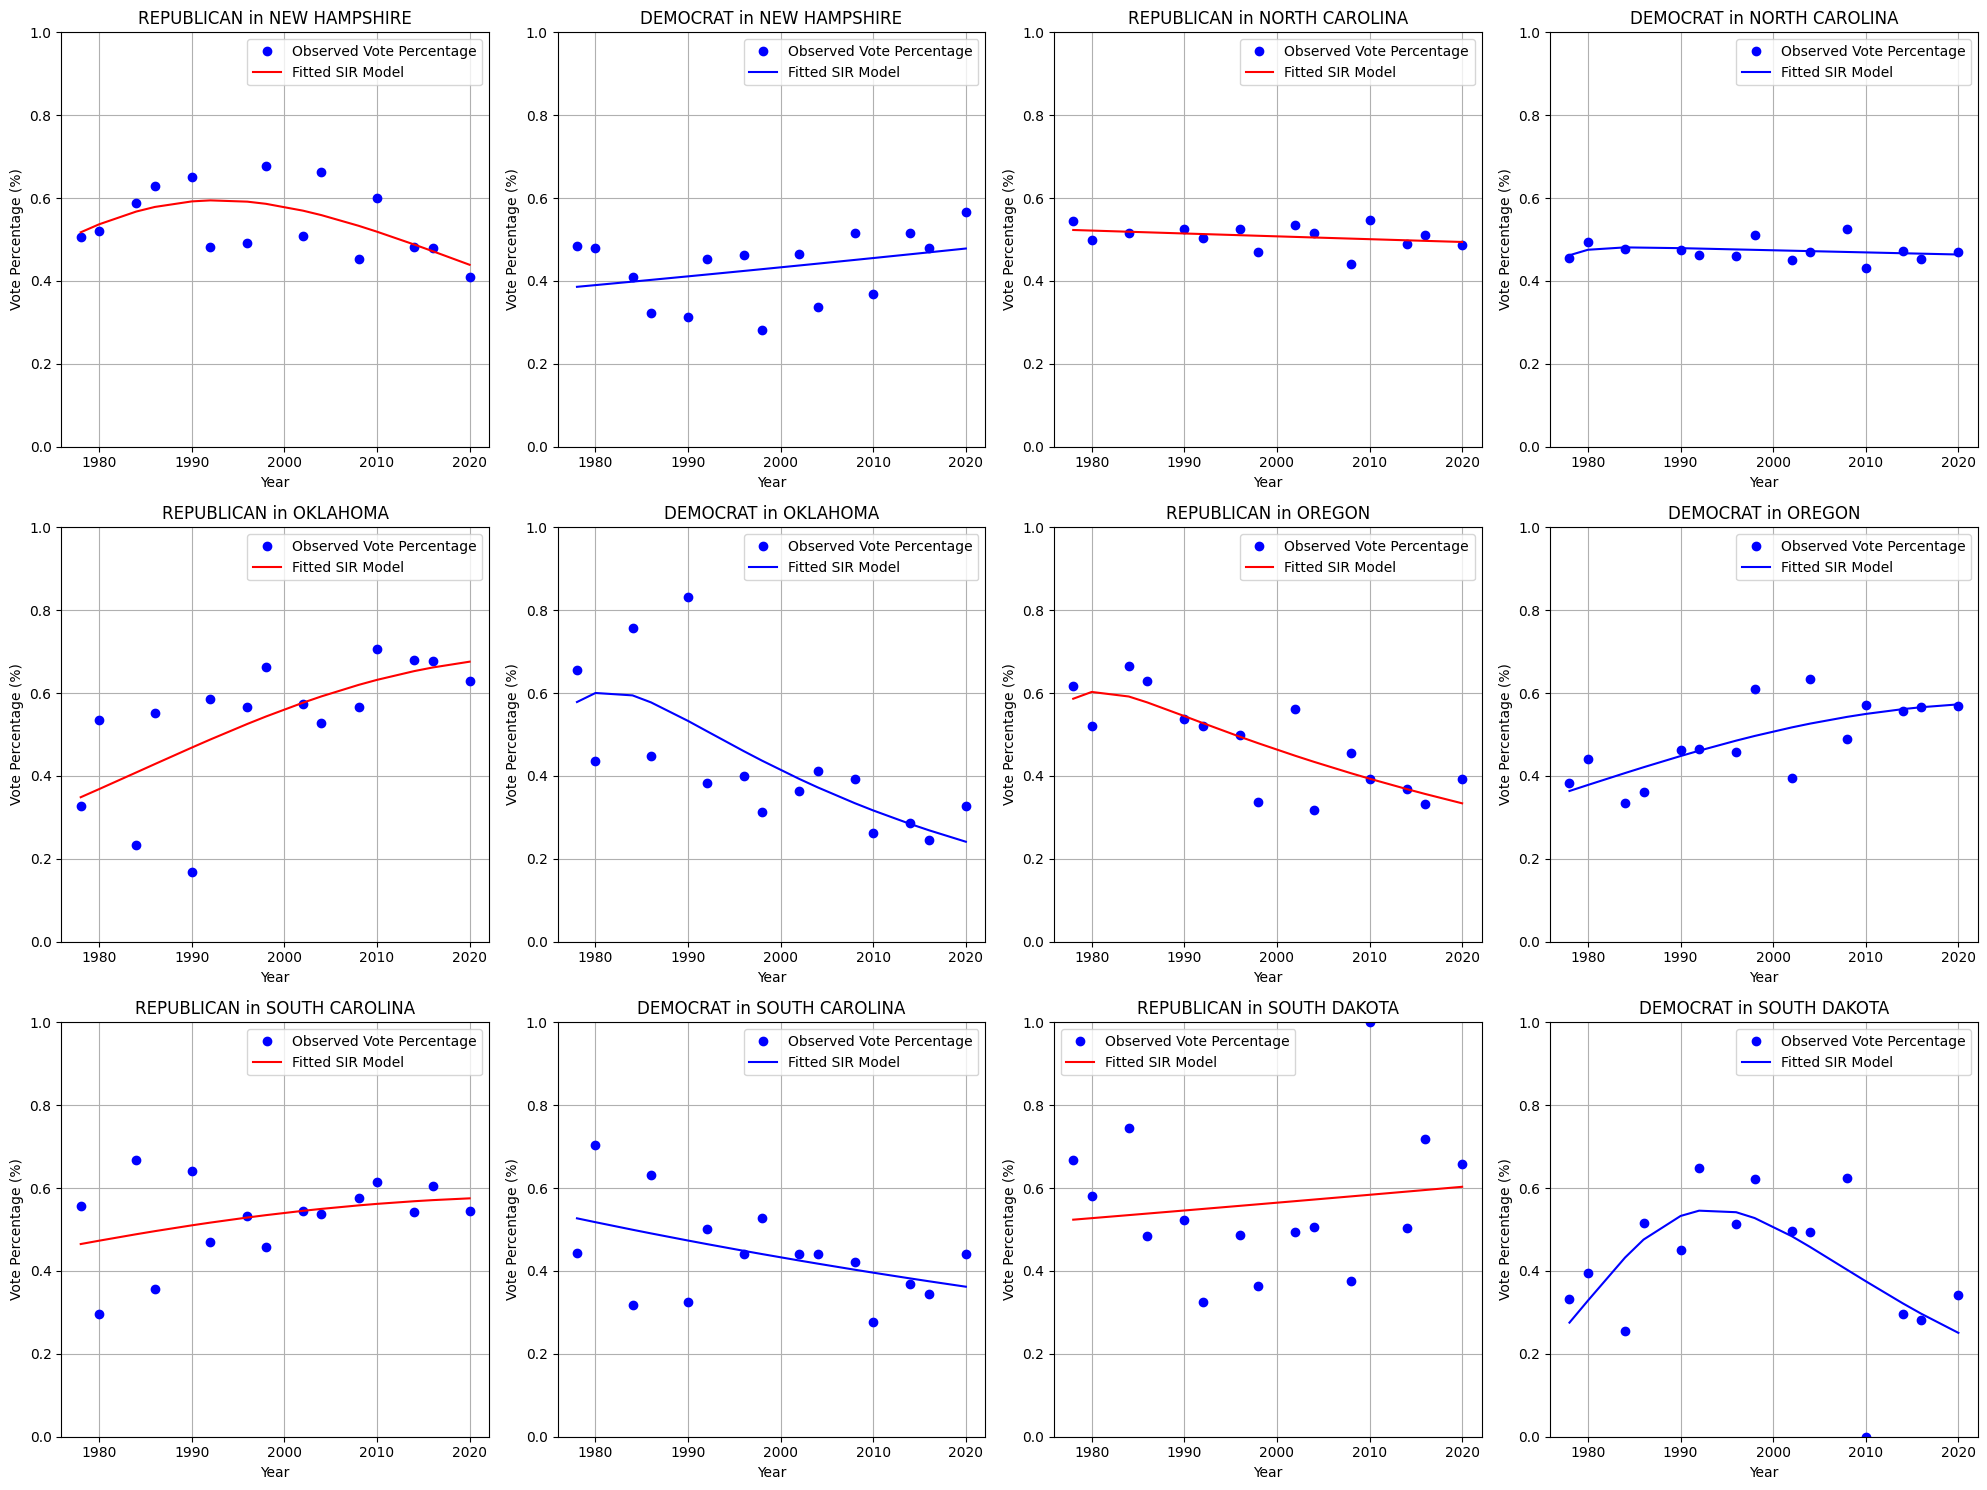

In [61]:
num_plots = len(states) * len(party_order)
cols = 4  # Number of columns in the grid
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()
ssr = {}
plot_index = 0
for state in states:
    for party in party_order:
        index = (state, party)
        year = df_dict[index]['year'].values
        votes = df_dict[index]['candidatevotes'].values
        total_votes = df_dict[index]['totalvotes'].values
        vote_percentage = votes / total_votes
        I0 = vote_percentage[0]
        S0 = 1 - I0
        R0 = 0

        # fit the curve provided initial guess. 0.1 each | Gives local optimum
        params, covariance = curve_fit(fit_sir_model, year, vote_percentage, p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))
        beta, gamma = params[:2]
        print(f"Fitted parameters: beta={beta}, gamma={gamma} for the state {state} and party {party}")
        fitted_voter_percentage = fit_sir_model(year, *params)
        ssr[index] = np.sqrt(np.mean(np.dot((fitted_voter_percentage - vote_percentage).T, (fitted_voter_percentage - vote_percentage)))) * 100
        ax = axes[plot_index]
        ax.plot(year, vote_percentage, 'bo', label='Observed Vote Percentage')
        ax.plot(year, fitted_voter_percentage, label='Fitted SIR Model', color=colors[party])
        ax.set_title(f'{party} in {state}')
        ax.set_xlabel('Year')
        ax.set_ylabel('Vote Percentage (%)')
        ax.set_ylim(0, 1)
        ax.legend()
        ax.grid(True)
        plot_index += 1
        
for i in range(plot_index, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [62]:
ssr

{('NEW HAMPSHIRE', 'REPUBLICAN'): 25.76717620921564,
 ('NEW HAMPSHIRE', 'DEMOCRAT'): 30.274414048891984,
 ('NORTH CAROLINA', 'REPUBLICAN'): 10.082360386439674,
 ('NORTH CAROLINA', 'DEMOCRAT'): 8.781055520907787,
 ('OKLAHOMA', 'REPUBLICAN'): 45.29631304543646,
 ('OKLAHOMA', 'DEMOCRAT'): 46.6034809716443,
 ('OREGON', 'REPUBLICAN'): 26.19044718756916,
 ('OREGON', 'DEMOCRAT'): 23.805486528259728,
 ('SOUTH CAROLINA', 'REPUBLICAN'): 35.110012066066076,
 ('SOUTH CAROLINA', 'DEMOCRAT'): 38.45979553948994,
 ('SOUTH DAKOTA', 'REPUBLICAN'): 64.53762877486156,
 ('SOUTH DAKOTA', 'DEMOCRAT'): 51.82284450371532}

Grid Search

In [63]:
def sir_model2(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I  - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

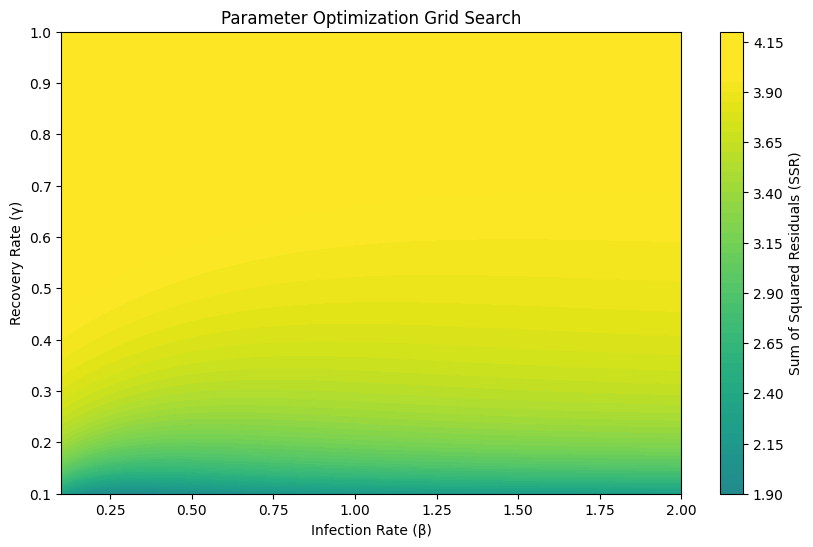

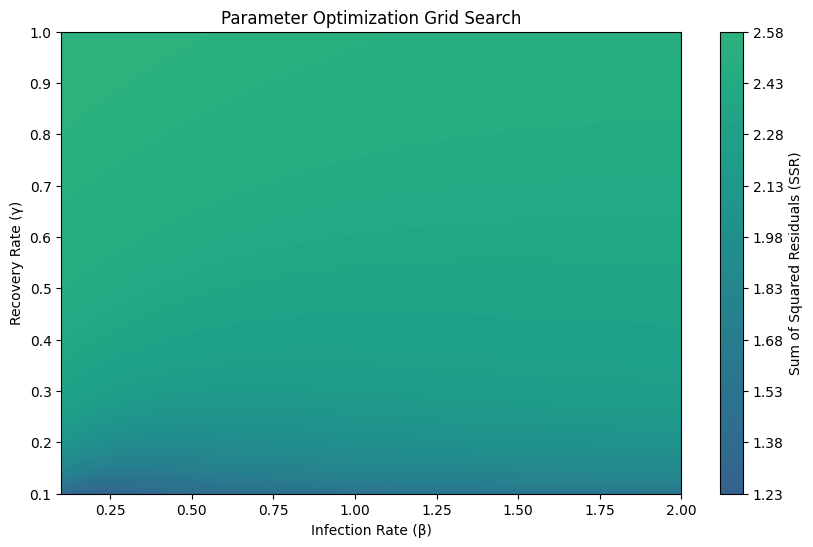

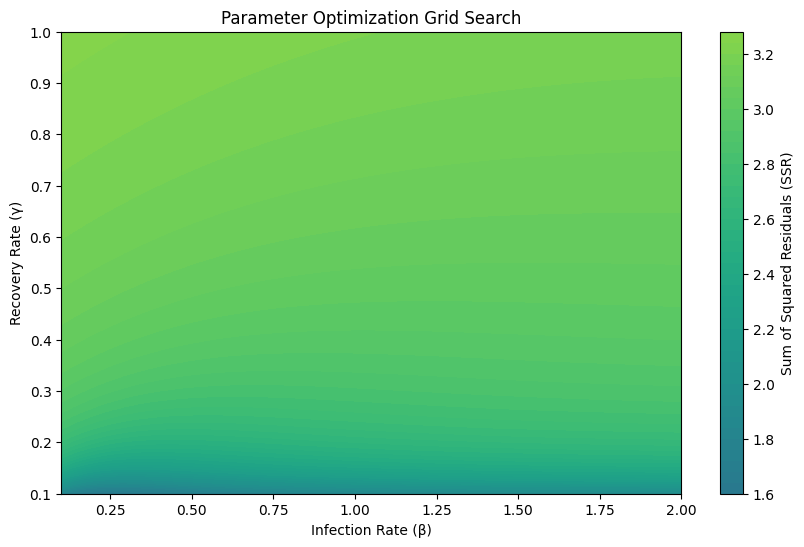

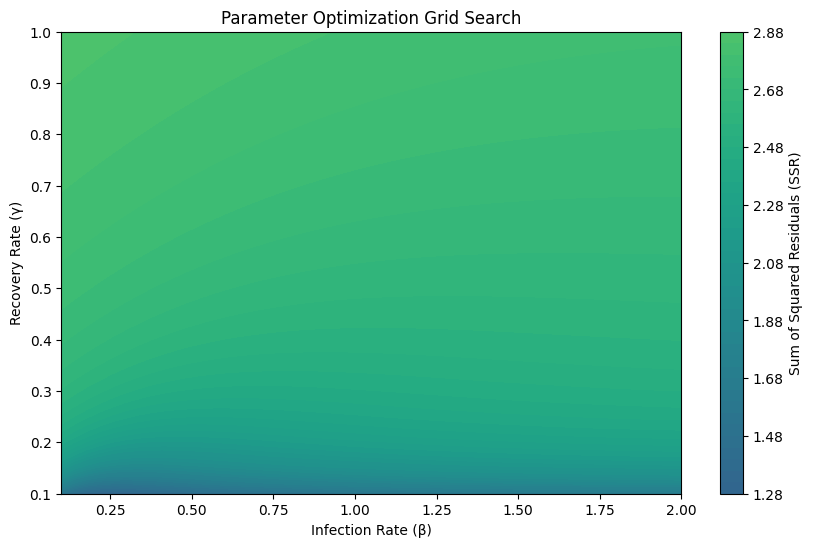

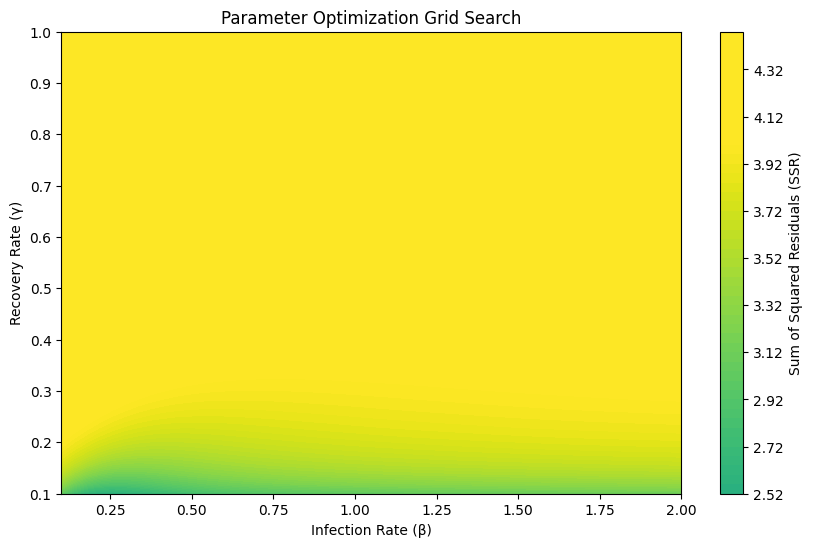

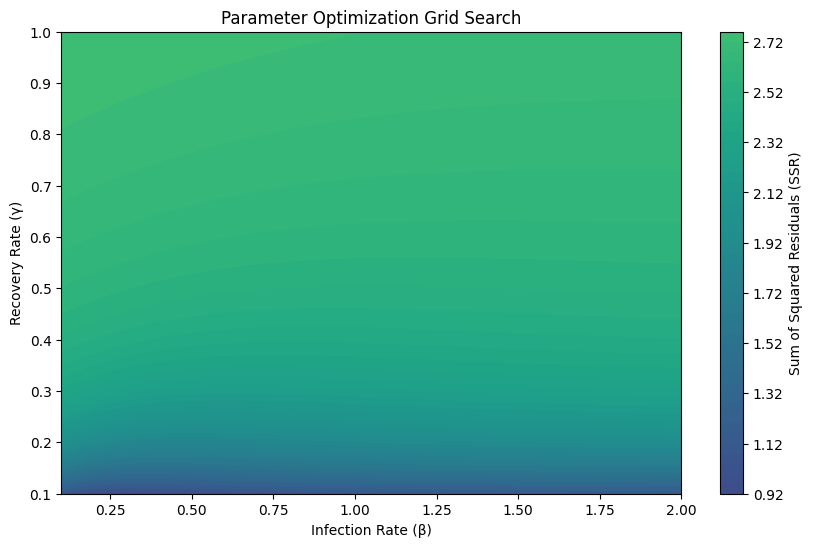

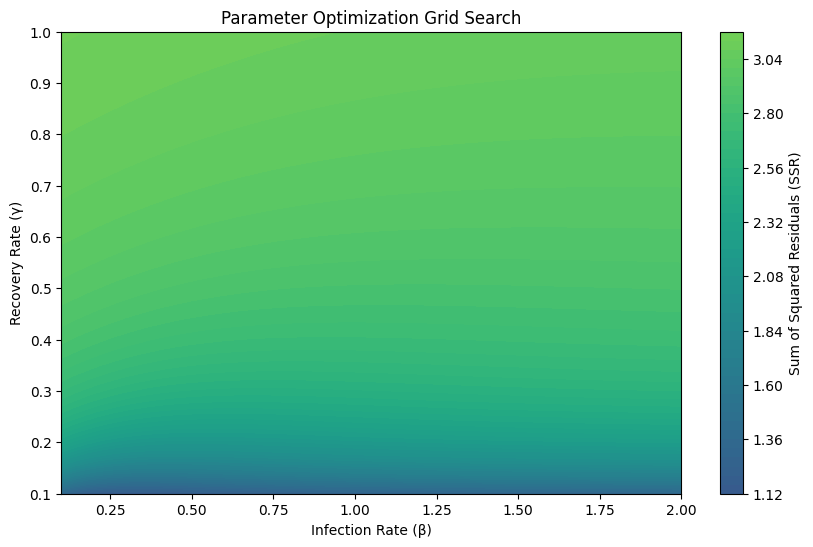

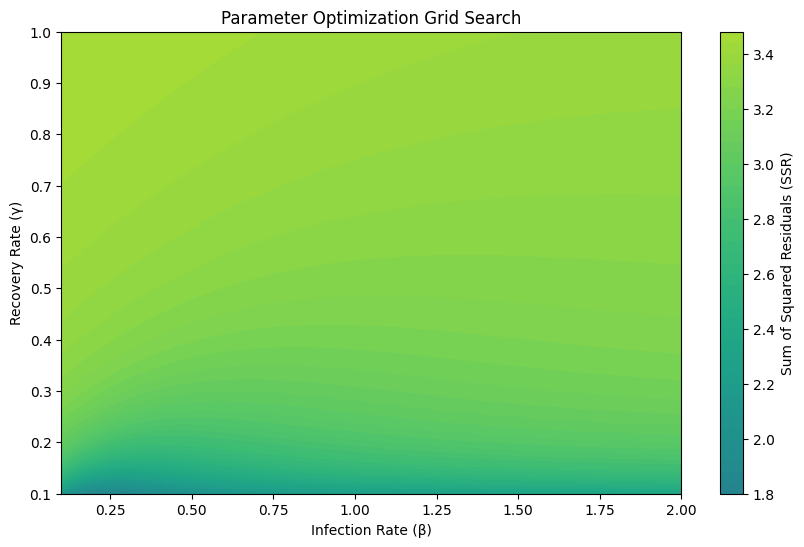

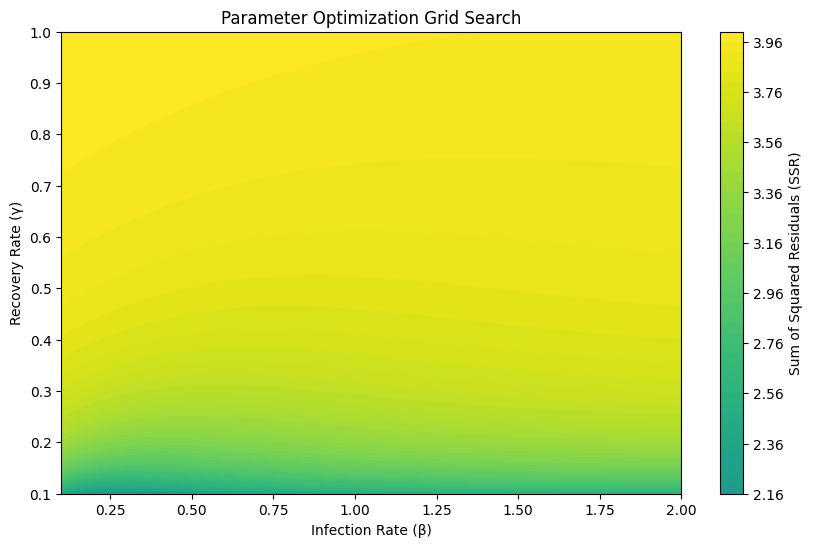

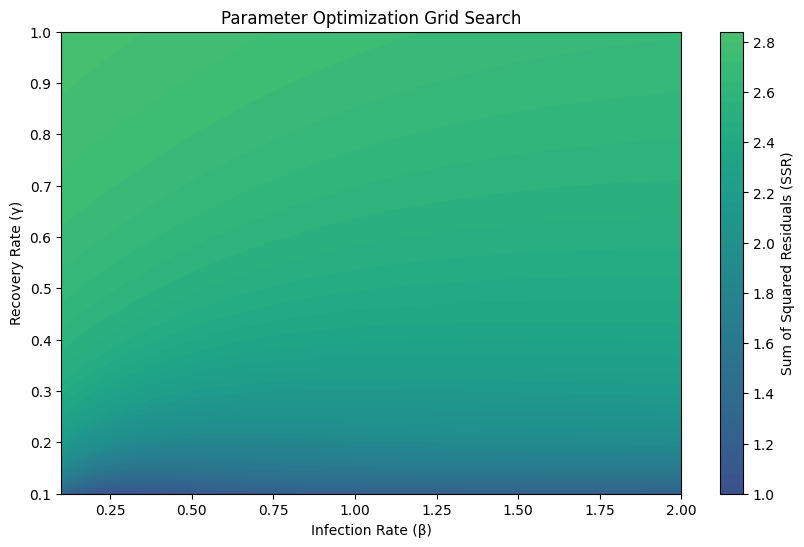

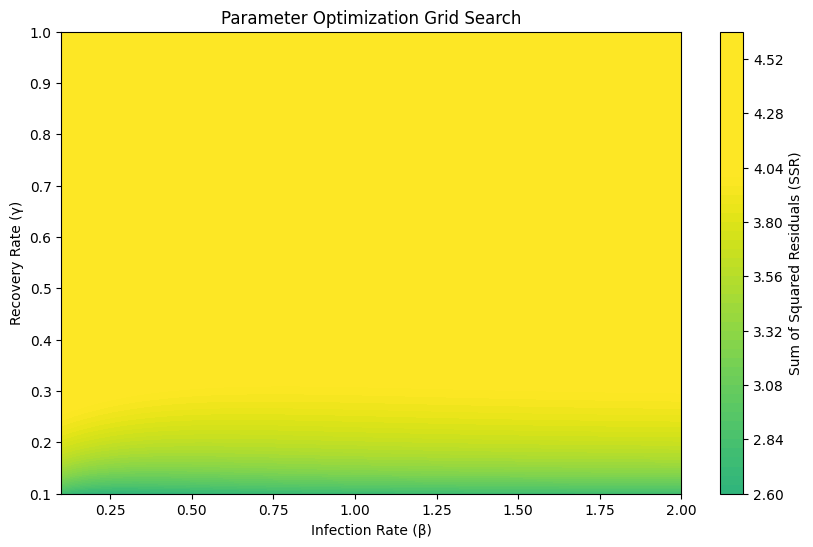

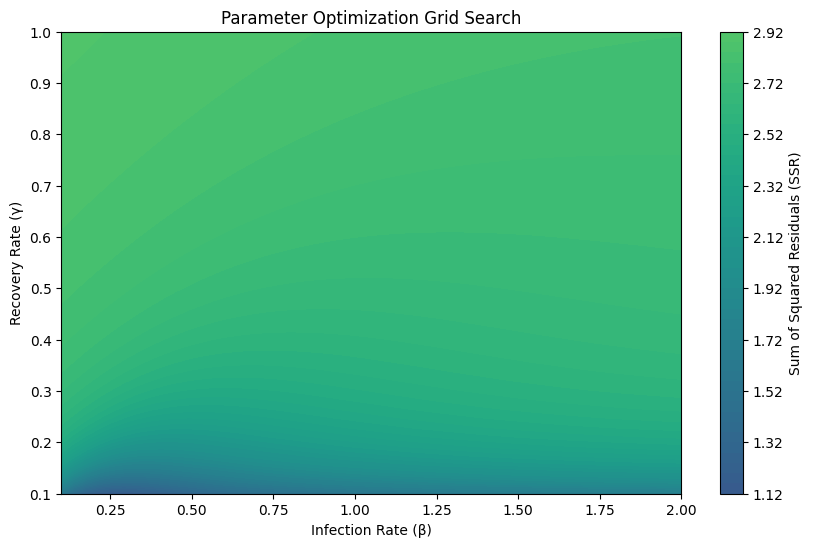

In [64]:
num_plots = len(states) * len(party_order)
cols = 4  # Number of columns in the grid
rows = math.ceil(num_plots / cols)

ssr = {}
beta_vals = np.linspace(0.1, 2.0, 50)
gamma_vals = np.linspace(0.1, 1.0, 50)
B, G = np.meshgrid(beta_vals, gamma_vals)
ssr_grid = np.zeros_like(B)

for state in states:
    for party in party_order:
        index = (state, party)
        year = df_dict[index]['year'].values
        votes = df_dict[index]['candidatevotes'].values
        total_votes = df_dict[index]['totalvotes'].values
        vote_percentage = votes / total_votes
        I0 = vote_percentage[0]
        S0 = 1 - I0
        R0 = 0

        for i in range(len(beta_vals)):
            for j in range(len(gamma_vals)):
                sol = odeint(sir_model2, [S0, I0, R0], year, args=(B[i,j], G[i,j]))
                I_pred = sol[:, 1]
                ssr_grid[i,j] = np.sum((I_pred - vote_percentage)**2)

        # Create heatmap plot
        plt.figure(figsize=(10, 6))
        contour = plt.contourf(B, G, ssr_grid, levels=50, cmap='viridis', vmin=0, vmax=4)
        plt.colorbar(contour, label='Sum of Squared Residuals (SSR)')
        plt.xlabel('Infection Rate (β)')
        plt.ylabel('Recovery Rate (γ)')
        plt.title('Parameter Optimization Grid Search')
        plt.show()

# Evolutionary Algorithm

In [65]:
from deap import base, creator, tools, algorithms
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
import random
import pandas as pd
import matplotlib.pyplot as plt

In [66]:
def sir_model1(y, t, beta, gamma, N):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

In [67]:
def fitness_function(params, t, data_I, N):
    beta, gamma = params
    S0, I0, R0 = N - data_I[0], data_I[0], 0  # Assume S0 is total population minus initial I
    y0 = S0, I0, R0

    # Solve ODEs
    sol = odeint(sir_model1, y0, t, args=(beta, gamma, N))

    # Compute the squared error for the infected population
    I_model = sol[:, 1]  # Extract the infected population from the model
    error_I = np.sum((I_model - data_I) ** 2)

    return error_I,

In [68]:
def sir_model(t, y, beta, gamma):
    '''' y is tuple with 
    (S, I, R) - > (Voters (infuencible), Opioniated voters (voter percentage for chosen candidate), Recovered (Voters who change sides) 
    
    '''
    S, I, R = y
    dSdt = -beta * S * I # It can go both ways ? 
    dIdt = beta * S * I - gamma * I # what is the mechanism for this. What is gamma a function of ? 
    dRdt = gamma * I # potenitally, beta and gamma are funcitons of time ? 
    return [dSdt, dIdt, dRdt]

In [69]:
def fit_sir_model(t, beta, gamma, S0, I0, R0):
    '''What is the return value?'''
    sol = solve_ivp(sir_model, [t[0], t[-1]], [S0, I0, R0], t_eval=t, args=(beta, gamma))
    return sol.y[1] # returns S, I, R as they change wrt time. y[1] gives I 

In [70]:
def run_ga(data_I, t, N):
    # Define the problem as a minimization problem
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize fitness
    creator.create("Individual", list, fitness=creator.FitnessMin)

    # Initialize the individual and population
    def create_individual():
        return [random.uniform(0, 1) for _ in range(2)]  # Beta and Gamma values

    # Register the components for the GA
    toolbox = base.Toolbox()
    toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", fitness_function, t=t, data_I=data_I, N=N)

    # Create the population
    population = toolbox.population(n=50)

    # Set the parameters for the genetic algorithm
    ngen = 100  # number of generations
    cxpb = 0.7  # probability of mating
    mutpb = 0.2  # probability of mutation

    # Run the genetic algorithm
    algorithms.eaSimple(population, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=ngen, 
                        stats=None, halloffame=None, verbose=True)

    # Extract the best individual (solution)
    best_individual = tools.selBest(population, 1)[0]
    return best_individual

In [71]:
df = pd.read_csv("1976-2020-senate.csv")

In [72]:
selected_states = ['NEW HAMPSHIRE', 'NORTH CAROLINA', 'OKLAHOMA', 'OREGON', 'SOUTH CAROLINA', 'SOUTH DAKOTA']
filtered_df = df[df['state'].isin(selected_states)]

In [73]:
states = filtered_df['state'].unique()
party_order = ['REPUBLICAN', 'DEMOCRAT']
colors = {'REPUBLICAN': 'red', 'DEMOCRAT': 'blue'} # BONUS 
df_dict = {}

plot_index = 0
for state in states:
    for party in party_order:
        state_party_data = df[(df['state'] == state) & (df['party_simplified'] == party)]
        state_party_data = state_party_data[state_party_data['writein'] == False]
        df_dict[(state, party)] = state_party_data

In [74]:
year = df_dict[('OREGON', 'REPUBLICAN')]['year'].values
votes = df_dict[('OREGON', 'REPUBLICAN')]['candidatevotes'].values
total_votes = df_dict[('OREGON', 'REPUBLICAN')]['totalvotes'].values
vote_percentage = votes / total_votes

In [75]:
N = 10000
best_params = run_ga(vote_percentage, year, N)
beta, gamma = best_params
I0 = vote_percentage[0]
S0 = 1 - I0
R0 = 0
print(f"Best parameters from GA: beta={beta}, gamma={gamma}")
params, covariance = curve_fit(fit_sir_model, year, vote_percentage, p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))
ea_fit = (fit_sir_model(year, *params))

gen	nevals
0  	50    
1  	39    
2  	38    
3  	36    
4  	37    
5  	30    
6  	32    
7  	42    
8  	35    
9  	40    
10 	41    
11 	33    
12 	37    
13 	32    
14 	37    
15 	40    
16 	33    
17 	35    
18 	45    
19 	41    
20 	44    
21 	41    
22 	45    
23 	39    
24 	39    
25 	40    
26 	35    
27 	45    
28 	35    
29 	38    
30 	34    
31 	38    
32 	33    
33 	33    
34 	36    
35 	42    
36 	43    
37 	36    
38 	42    
39 	41    
40 	39    
41 	40    
42 	35    
43 	26    
44 	37    
45 	36    
46 	31    
47 	38    
48 	38    
49 	39    
50 	37    
51 	35    
52 	39    
53 	39    
54 	39    
55 	37    
56 	37    
57 	30    
58 	32    
59 	42    
60 	38    
61 	39    
62 	43    
63 	36    
64 	37    
65 	43    
66 	34    
67 	37    
68 	41    
69 	30    
70 	27    
71 	35    
72 	41    
73 	42    
74 	36    
75 	38    
76 	37    
77 	38    
78 	38    
79 	34    
80 	32    
81 	41    
82 	37    
83 	36    
84 	36    
85 	32    
86 	32    
87 	35    
88 	40    
89 	40    

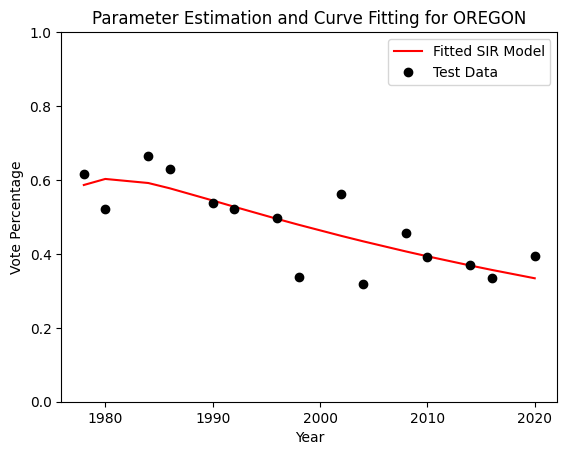

In [76]:
plt.plot(year, ea_fit, 'r-', label='Fitted SIR Model')
plt.plot(year, vote_percentage, 'ko', label='Test Data')
plt.xlabel('Year')
plt.ylabel('Vote Percentage')
plt.ylim(0, 1)
plt.legend()
plt.title('Parameter Estimation and Curve Fitting for OREGON')
plt.show()

# Predator Prey Model

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
import numpy as np

In [78]:
df = pd.read_csv("1976-2020-senate.csv")

In [79]:
df
df_mod = df[df['stage'] == 'gen']
df_mod = df_mod[df_mod['party_simplified'].isin(['REPUBLICAN', 'DEMOCRAT'])]
grouped = df_mod.groupby(['year', 'party_simplified'])['candidatevotes'].sum().unstack().fillna(0)
grouped['Total'] = grouped.sum(axis=1)
grouped['DEMOCRAT_pct'] = 100 * grouped['DEMOCRAT'] / grouped['Total']
grouped['REPUBLICAN_pct'] = 100 * grouped['REPUBLICAN'] / grouped['Total']

In [80]:
years = grouped.index.values
t = years - years[0]
vote_A = grouped['DEMOCRAT_pct'].values
vote_B = grouped['REPUBLICAN_pct'].values
initial_conditions = [vote_A[0], vote_B[0]]

In [81]:
def lotka_volterra(y, t, alpha, beta, delta, gamma):
    x, y_val = y
    dxdt = alpha * x - beta * x * y_val
    dydt = delta * x * y_val - gamma * y_val
    return [dxdt, dydt]

In [82]:
def modified_lv(y, t, alpha, beta, delta, gamma, K=100):
    x, y_val = y
    dxdt = alpha * x * (1 - x / K) - beta * x * y_val
    dydt = delta * x * y_val - gamma * y_val * (1 - y_val / K)
    return [dxdt, dydt]

In [83]:
def objective(params):
    alpha, beta, delta, gamma = params
    sol = odeint(modified_lv, initial_conditions, t, args=(alpha, beta, delta, gamma))
    x_model, y_model = sol.T
    return np.sum((vote_A - x_model)**2 + (vote_B - y_model)**2)

In [84]:
initial_guess = [1e-5, 1e-5, 1e-5, 1e-5]
bounds = [(0, 1)] * 4
result = minimize(objective, initial_guess, bounds=bounds)
alpha, beta, delta, gamma = result.x
print(f"Fitted parameters: alpha={alpha:.4f}, beta={beta:.4f}, delta={delta:.4f}, gamma={gamma:.4f}")

Fitted parameters: alpha=0.0000, beta=0.0001, delta=0.0001, gamma=0.0000


In [85]:
sol = odeint(modified_lv, initial_conditions, t, args=(alpha, beta, delta, gamma))
x_model, y_model = sol.T

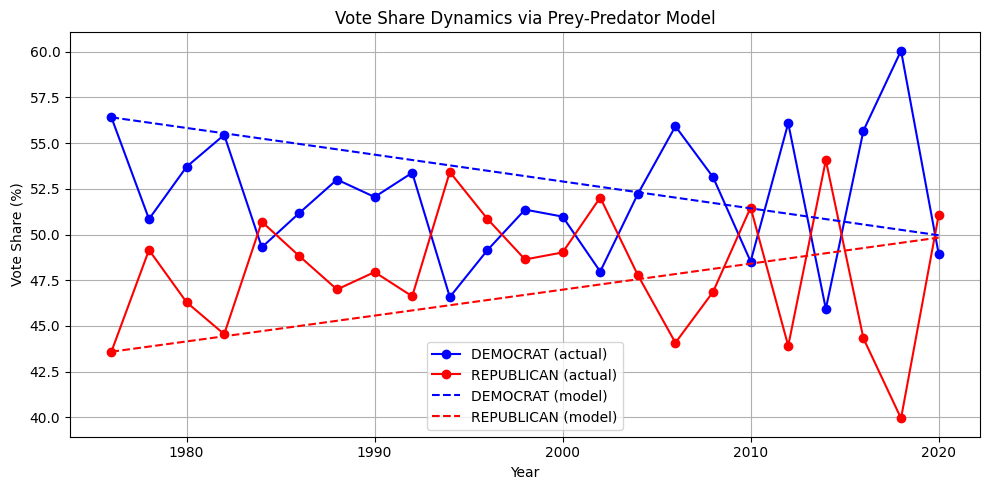

In [86]:
plt.figure(figsize=(10, 5))
plt.plot(years, vote_A, 'bo-', label="DEMOCRAT (actual)")
plt.plot(years, vote_B, 'ro-', label="REPUBLICAN (actual)")
plt.plot(years, x_model, 'b--', label="DEMOCRAT (model)")
plt.plot(years, y_model, 'r--', label="REPUBLICAN (model)")
plt.xlabel("Year")
plt.ylabel("Vote Share (%)")
plt.title("Vote Share Dynamics via Prey-Predator Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()